In [580]:
import requests
import pandas as pd
import numpy as np

import json
import geopandas
from shapely.geometry import Point

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [581]:
def preprocess(df, text_field):
    
    df[text_field] = df[text_field].str.lower()
    
    # удалить ненужные символы и слова
    df[text_field] = df[text_field].str.replace("ё", "e", regex=False)
    df[text_field] = df[text_field].str.replace(",", "", regex=False)
    df[text_field] = df[text_field].str.replace("район", "", regex=False)
    df[text_field] = df[text_field].str.replace("[\"]", "", regex=True)
    df[text_field] = df[text_field].str.replace("\n", "", regex=False)
    df[text_field] = df[text_field].str.replace("поселение", "", regex=False)
    df[text_field] = df[text_field].str.replace("городской округ", "", regex=False)
    df[text_field] = df[text_field].str.replace("административный округ", "", regex=False)
    df[text_field] = df[text_field].str.replace("admarea:", "", regex=False)
    df[text_field] = df[text_field].str.replace("district:", "", regex=False)
    
    # трим нескольких пробелов между словами и удаление крайних пробелов в строке
    df[text_field] = df[text_field].str.replace(r"\s+", " ", regex=True)
    df[text_field] = df[text_field].str.replace(r"^[ \s]+|[ \s]+$", "", regex=True)
    
    return df


In [582]:
# подгружаем сгруппированные данные

arenda_and_vacancy = pd.read_excel(r"..\data\artefacts\arenda_and_vacancy.xlsx", index_col=0)
district_company_count = pd.read_excel(r"..\data\artefacts\district_company_count.xlsx", index_col=0)
district_income = pd.read_excel(r"..\data\artefacts\district_income.xlsx", index_col=0)
metro_traffic = pd.read_excel(r"..\data\artefacts\metro_traffic.xlsx", index_col=0)

edu = pd.read_excel(r"..\data\artefacts\edu.xlsx", index_col=0)
leisures = pd.read_excel(r"..\data\artefacts\leisures.xlsx", index_col=0)
services = pd.read_excel(r"..\data\artefacts\services.xlsx", index_col=0)
social = pd.read_excel(r"..\data\artefacts\social.xlsx", index_col=0)

# подгружаем районы
neighborhoods = pd.read_excel(r"..\data\artefacts\neighborhoods.xlsx", index_col=0)

In [583]:
# ниже все наборы мержим в один датафрейм

In [584]:
common_data = neighborhoods.merge(arenda_and_vacancy, how="left", on="neighborhood")
common_data = common_data.drop(columns=["administrative_district_y"])

In [585]:
common_data = common_data.merge(district_company_count, how="left", left_on="neighborhood", right_on="Субъект федерации")
common_data = common_data.drop(columns=["Субъект федерации"])

In [586]:
common_data = common_data.merge(district_income, how="left", left_on="neighborhood", right_on="Субъект федерации")
common_data = common_data.drop(columns=["Субъект федерации"])

In [587]:
common_data = common_data.merge(metro_traffic, how="left", left_on="neighborhood", right_on="Район")
common_data = common_data.drop(columns=["Район"])

In [588]:
common_data = common_data.merge(edu, how="left", on="neighborhood")
common_data = common_data.drop(columns=["administrative_district"])

In [589]:
common_data = common_data.merge(leisures, how="left", on="neighborhood")
common_data = common_data.drop(columns=["administrative_district"])

In [590]:
common_data = common_data.merge(services, how="left", on="neighborhood")
common_data = common_data.drop(columns=["administrative_district"])

In [591]:
common_data = common_data.merge(social, how="left", on="neighborhood")
common_data = common_data.drop(columns=["administrative_district"])

In [592]:
common_data = common_data.rename(columns={"administrative_district_x": "administrative_district"})
common_data = common_data.fillna(0)

# удаляем ненужные столбцы, они сильно коррелируют с площадью и населением
cols = ["edu_coverage", "edu_density", "leisures_density", "leisures_coverage", "services_density", "services_coverage",
       "socials_density", "socials_coverage"]
common_data = common_data.drop(columns=cols)

In [593]:
# оставить только старую москву, т.к. для новой москвы мало данных

districts = [
    "юго-западный",
    "северо-восточный",
    "центральный",
    "северный",
    "южный",
    "восточный",
    "западный",
    "юго-восточный",
    "зеленоградский",
    "северо-западный",
#         "Новомосковский",
#         "Троицкий"
]

old_moscow = common_data[common_data.administrative_district.isin(districts)]

In [594]:
# грузим геодатафрейм, карта МСК

path_to_data = r"..\data\hackaton_zones\adm2fishnet.csv"
df = pd.read_csv(path_to_data, sep=";")
gdf = geopandas.GeoDataFrame(df)
gdf["geometry"] = geopandas.GeoSeries.from_wkt(df['WKT'])
gdf.drop(columns=['WKT'], inplace=True)

gdf["boundary"] = gdf.geometry.boundary
gdf["area"] = gdf.geometry.area

In [595]:
# Матрица корреспонденции дом-работа

CMatrixHomeWork = pd.read_csv(r"..\data\hackatonsept2022\04_CMatrix_Home_work_202109.csv.gz")

In [596]:
# убираем тех, кто неизвестно где работает (-1), и к zid клеим названия районов

CMHW = CMatrixHomeWork[CMatrixHomeWork["work_zid"] != -1]

CMHW = CMHW.merge(gdf[["cell_zid", "adm_name"]], 
                             how="left", left_on="home_zid", right_on="cell_zid")
CMHW =  CMHW.merge(gdf[["cell_zid", "adm_name"]], 
                   how="left", left_on="work_zid", right_on="cell_zid")

CMHW.drop(columns=["cell_zid_x", "cell_zid_y"], inplace=True)
CMHW.rename(columns ={"adm_name_x": "home_district", "adm_name_y": "work_district"}, inplace=True)

In [597]:
# выносим местных рабочих

working_customers_from_same_dist = CMHW[CMHW.home_district == CMHW.work_district] \
                                    .groupby(["work_district"], as_index=False)[["customers_cnt"]].sum()
working_customers_from_same_dist = preprocess(working_customers_from_same_dist, "work_district")

In [598]:
# выносим приезжих рабочих

working_customers_from_other_dist = CMHW.groupby(["work_district"], as_index=False)[["customers_cnt"]].sum()
working_customers_from_other_dist = preprocess(working_customers_from_other_dist, "work_district")
working_customers_from_other_dist["customers_cnt"] = working_customers_from_other_dist["customers_cnt"] \
                                                    - working_customers_from_same_dist["customers_cnt"]

In [599]:
# прикрепляем всех рабочих к основному фрейму

old_moscow = old_moscow.merge(working_customers_from_other_dist, how="left", left_on="neighborhood", right_on="work_district")
old_moscow = old_moscow.merge(working_customers_from_same_dist, how="left", left_on="neighborhood", right_on="work_district")

In [600]:
# убираем ненужное и переименовываем корректно колонки

old_moscow.drop(columns=["work_district_x", "work_district_y"], inplace=True)

cols_to_rename = {
    "customers_cnt_x": "Неместные рабочие",
    "customers_cnt_y": "Местные рабочие",
    "neighborhood": "Район",
    "administrative_district": "Округ",
    "nhood_population_density_person_per_square_km": "Плотность населения, чел/кв.км",
    "Входы пассажиров в мес": "Траффик в метро, мес.",
    "Общая прибыль,млн рублей": "Общая прибыль района, млн. руб.",
    "sum_edu": "Кол-во обр. учреждений",
    "sum_leisures": "Кол-во парков и мест отдыха",
    "sum_services": "Кол-во оказываемых услуг/товаров",
    "sum_socials": "Кол-во соц. учреждений",
    }


old_moscow.rename(columns=cols_to_rename, inplace=True)

In [601]:
old_moscow

,Район,Округ,nhood_area_in_square_km,nhood_population,"Плотность населения, чел/кв.км",housing_area_thousand_square_meters,housing_area_square_meters_per_person,arenda_A,vacancy_lvl_A,arenda_B,...,"Средняя прибыль,млн рублей","Общая прибыль района, млн. руб.","Траффик в метро, мес.",Выходы пассажиров в мес,Кол-во обр. учреждений,Кол-во парков и мест отдыха,Кол-во оказываемых услуг/товаров,Кол-во соц. учреждений,Неместные рабочие,Местные рабочие
0,академический,юго-западный,583.0,110161,18895.54,24670.0,227.0,20.4,15.0,15.70,...,12.25,83394.03,1718142.5,1749839.0,15,98,749,32,55398.0,11707.0
1,алексеевский,северо-восточный,529.0,79193,14970.32,16079.0,205.0,21.2,32.5,15.00,...,9.44,59017.39,2668197.0,2629856.0,11,40,724,42,42619.0,8780.0
2,алтуфьевский,северо-восточный,325.0,57361,17649.54,8393.0,155.0,21.2,32.5,15.00,...,4.79,5476.08,0.0,0.0,5,41,199,9,20631.0,5954.0
3,арбат,центральный,211.0,35796,16964.93,7310.0,260.0,38.0,14.0,24.30,...,52.23,404661.20,1285433.0,1313924.0,8,27,901,52,61186.0,3583.0
4,аэропорт,северный,458.0,79283,17310.70,19397.0,259.0,35.9,7.5,16.79,...,9.35,51726.12,2803702.5,2860737.5,13,47,906,43,65488.0,9419.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,южное тушино,северо-западный,794.0,108872,13711.84,17149.0,169.0,36.3,4.0,17.10,...,3.19,13306.71,1313084.0,1295155.0,7,62,775,34,24872.0,10968.0
121,южнопортовый,юго-восточный,453.0,74508,16447.68,14490.0,206.0,17.0,20.0,18.90,...,3.48,15309.95,2348135.5,2429414.5,8,34,2499,17,47008.0,8246.0
122,якиманка,центральный,480.0,27791,5789.79,7887.0,298.0,38.0,14.0,24.30,...,63.67,485253.64,855015.5,896985.5,9,28,579,42,103219.0,6654.0
123,ярославский,северо-восточный,799.0,97502,12203.00,14045.0,153.0,21.2,32.5,15.00,...,5.55,18759.22,840258.5,852573.0,11,45,593,35,24079.0,9682.0


<AxesSubplot:>

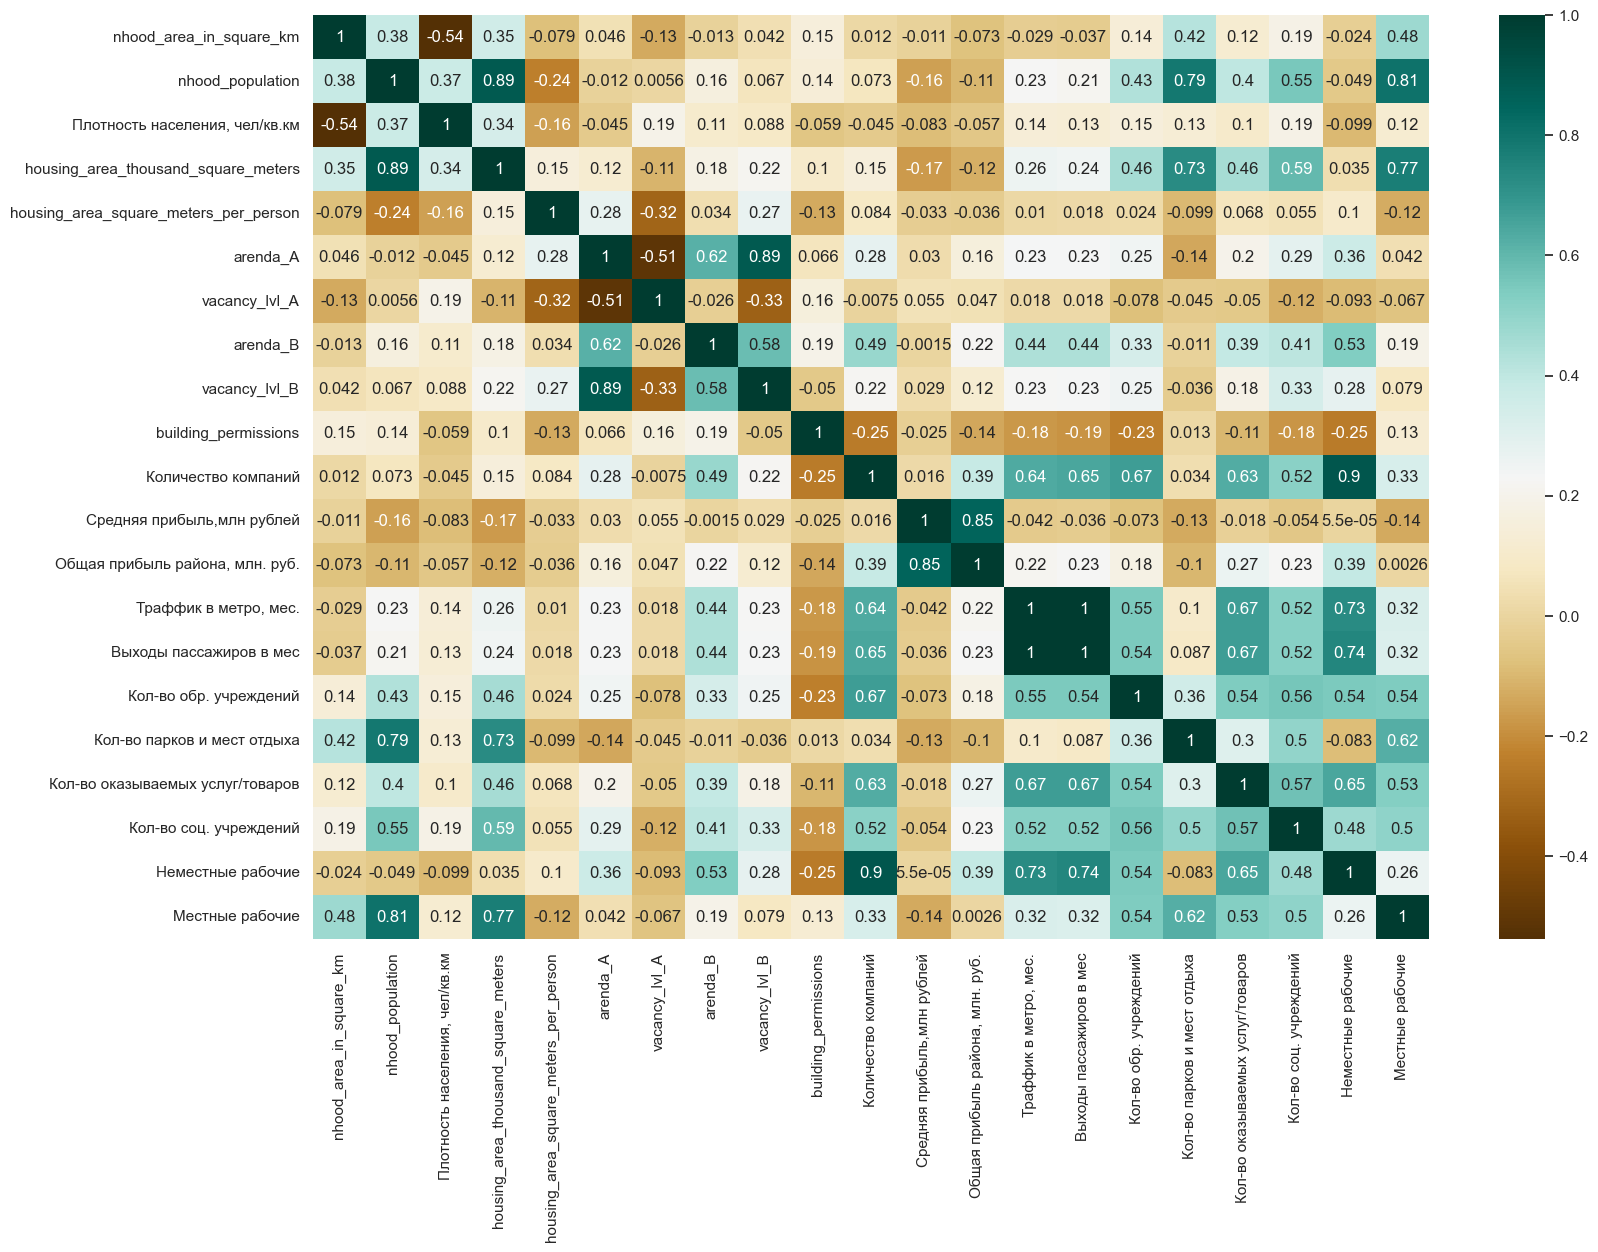

In [602]:
sns.set(rc={'figure.figsize':(18,12)})
sns.heatmap(old_moscow.corr(), cmap="BrBG", annot=True)

<AxesSubplot:>

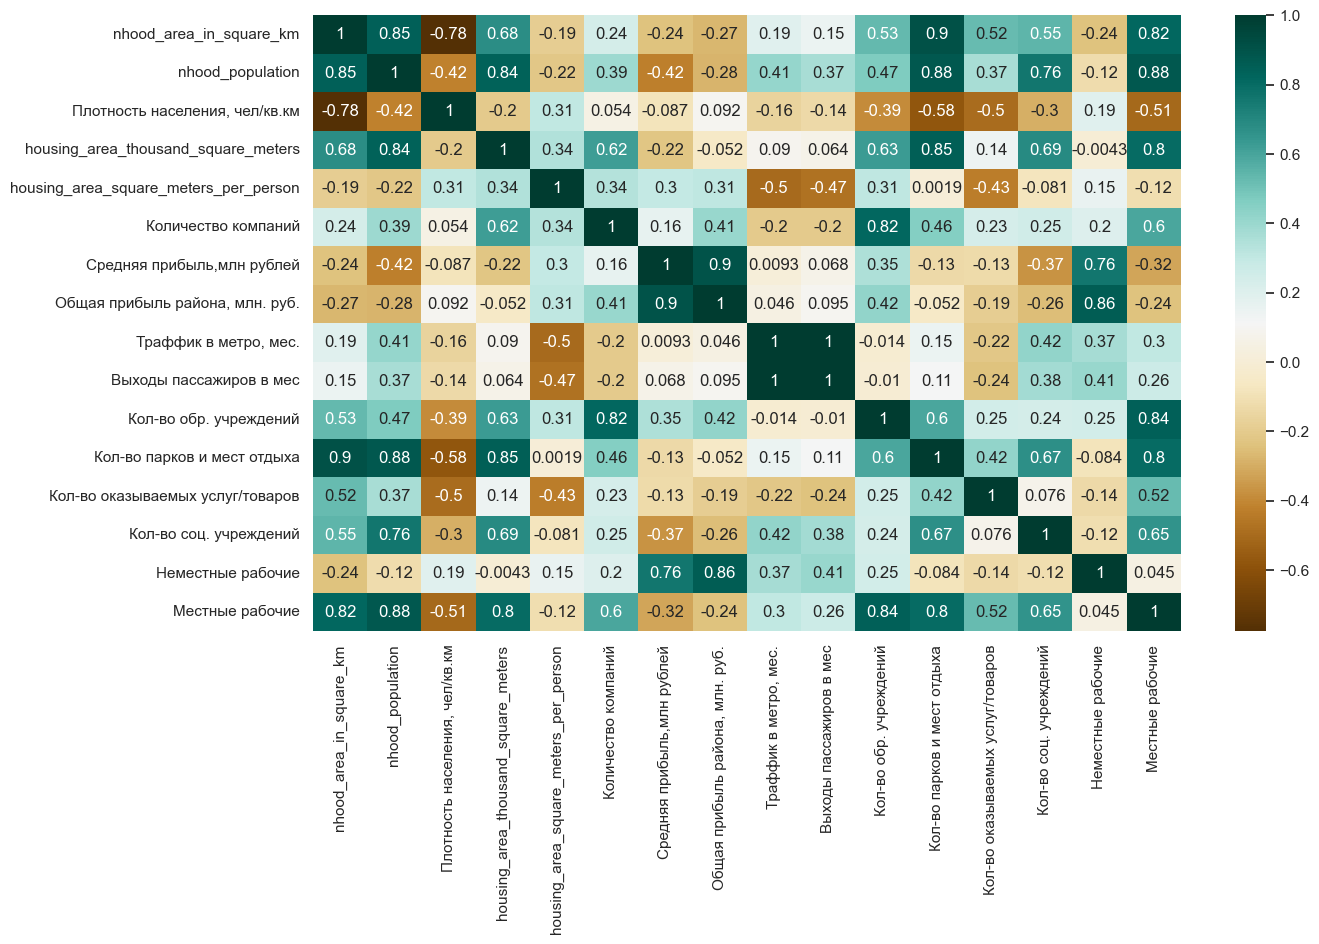

In [604]:
old_moscow_district = old_moscow.drop(columns=["arenda_A", "vacancy_lvl_A", "arenda_B", "vacancy_lvl_B", 
                                               "building_permissions"])
corr = old_moscow_district[old_moscow_district.Округ == "юго-западный"].corr()
sns.set(rc={'figure.figsize':(14,8)})
sns.heatmap(corr, cmap="BrBG", annot=True)

<AxesSubplot:>

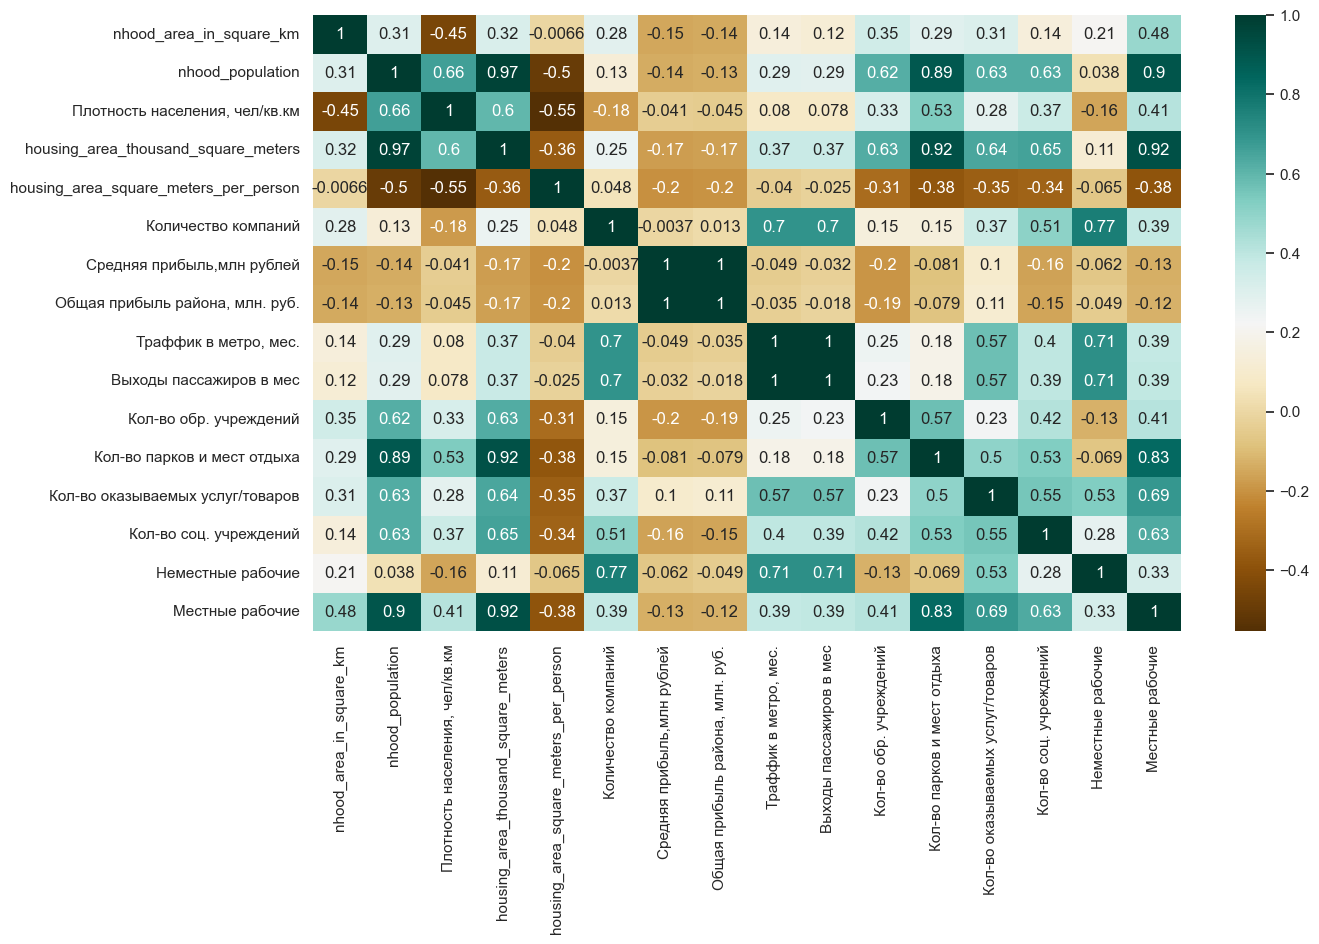

In [605]:
old_moscow_district = old_moscow.drop(columns=["arenda_A", "vacancy_lvl_A", "arenda_B", "vacancy_lvl_B", 
                                               "building_permissions"])
corr = old_moscow_district[old_moscow_district.Округ == "северо-восточный"].corr()
sns.set(rc={'figure.figsize':(14,8)})
sns.heatmap(corr, cmap="BrBG", annot=True)

<AxesSubplot:>

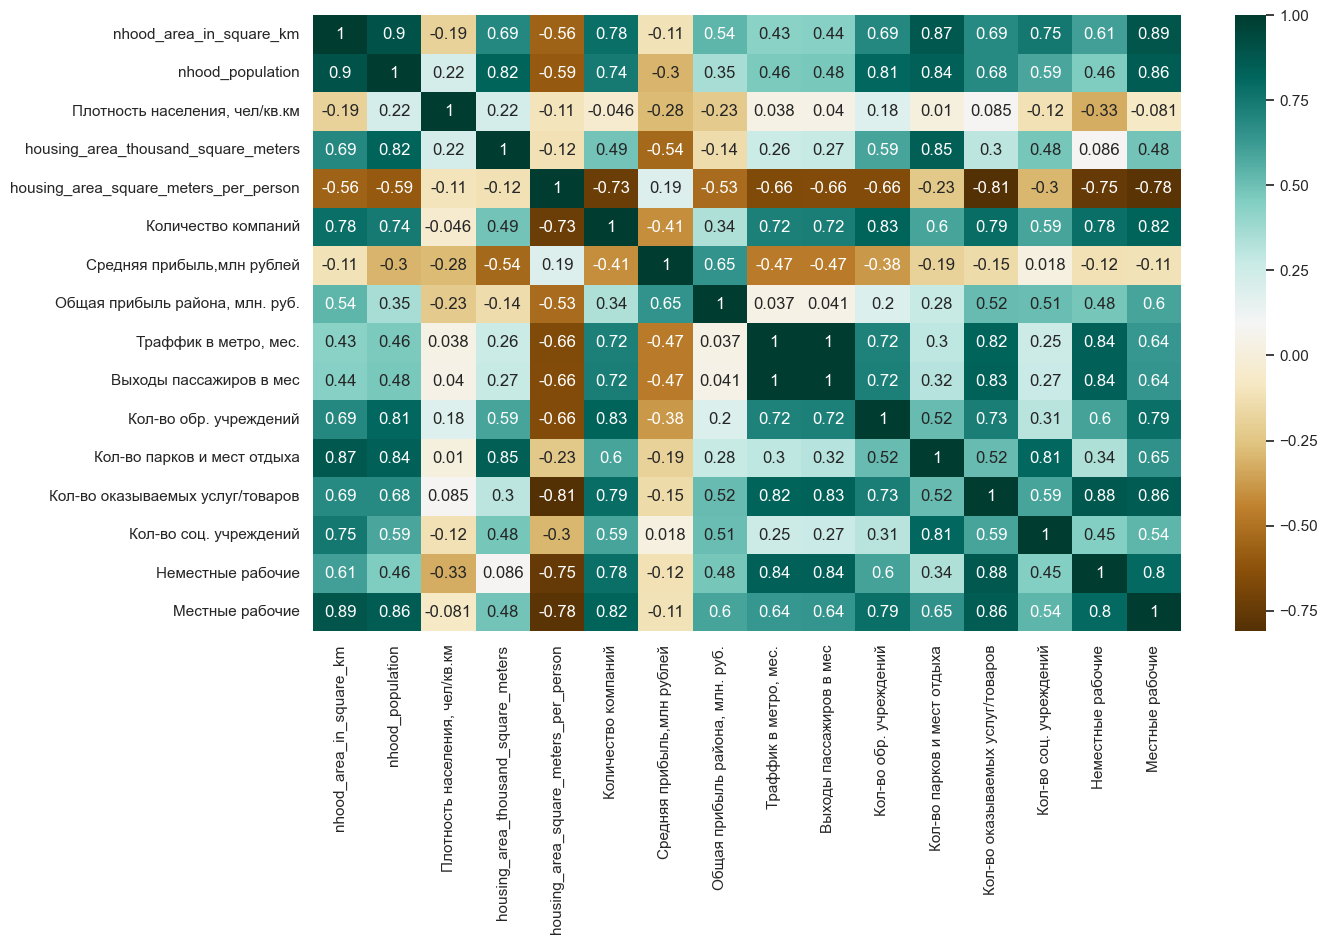

In [606]:
old_moscow_district = old_moscow.drop(columns=["arenda_A", "vacancy_lvl_A", "arenda_B", "vacancy_lvl_B", 
                                               "building_permissions"])
corr = old_moscow_district[old_moscow_district.Округ == "центральный"].corr()
sns.set(rc={'figure.figsize':(14,8)})
sns.heatmap(corr, cmap="BrBG", annot=True)

<AxesSubplot:>

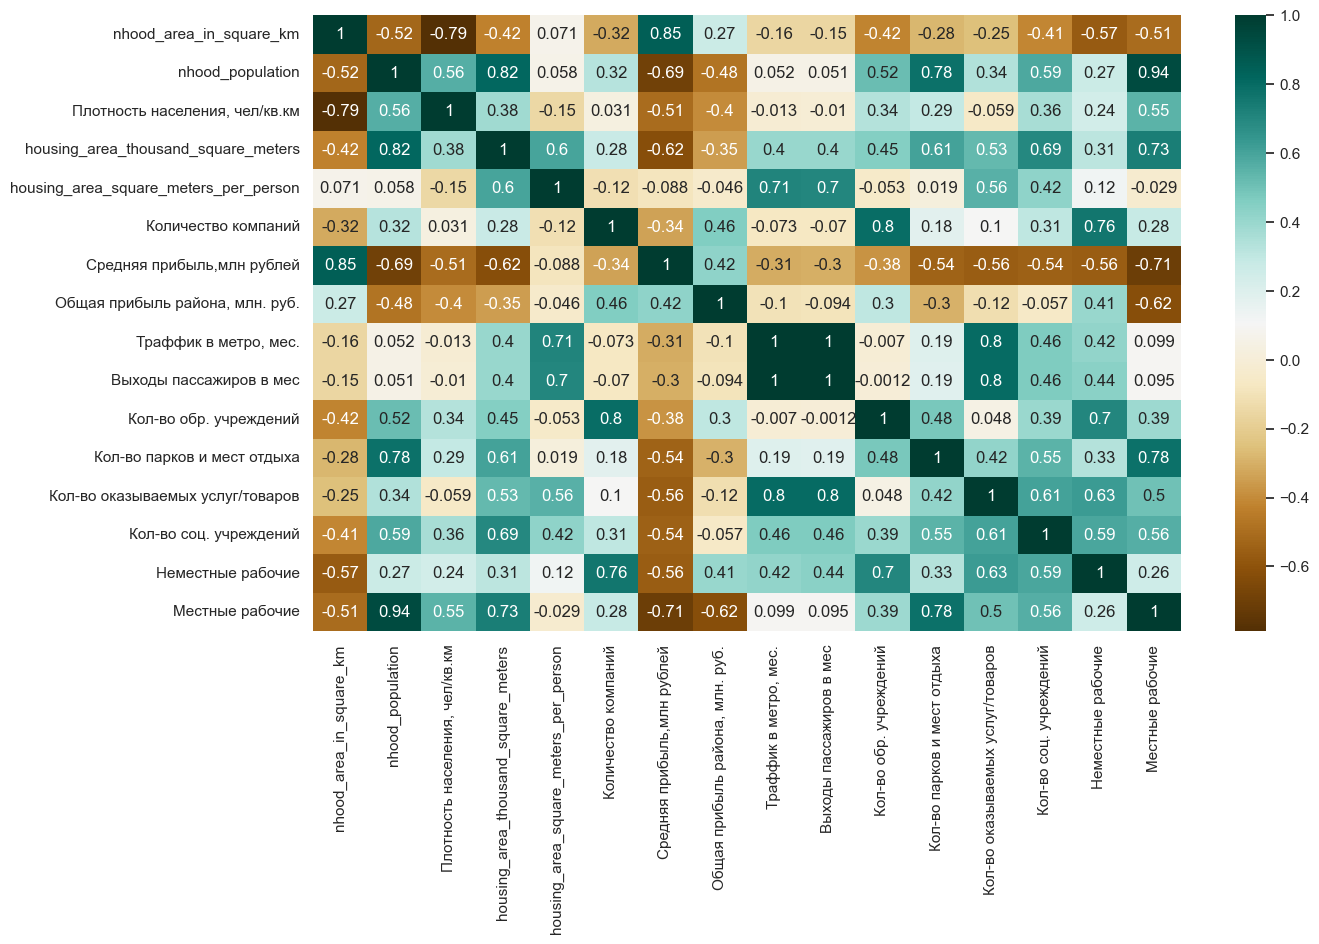

In [607]:
old_moscow_district = old_moscow.drop(columns=["arenda_A", "vacancy_lvl_A", "arenda_B", "vacancy_lvl_B", 
                                               "building_permissions"])
corr = old_moscow_district[old_moscow_district.Округ == "северный"].corr()
sns.set(rc={'figure.figsize':(14,8)})
sns.heatmap(corr, cmap="BrBG", annot=True)

<AxesSubplot:>

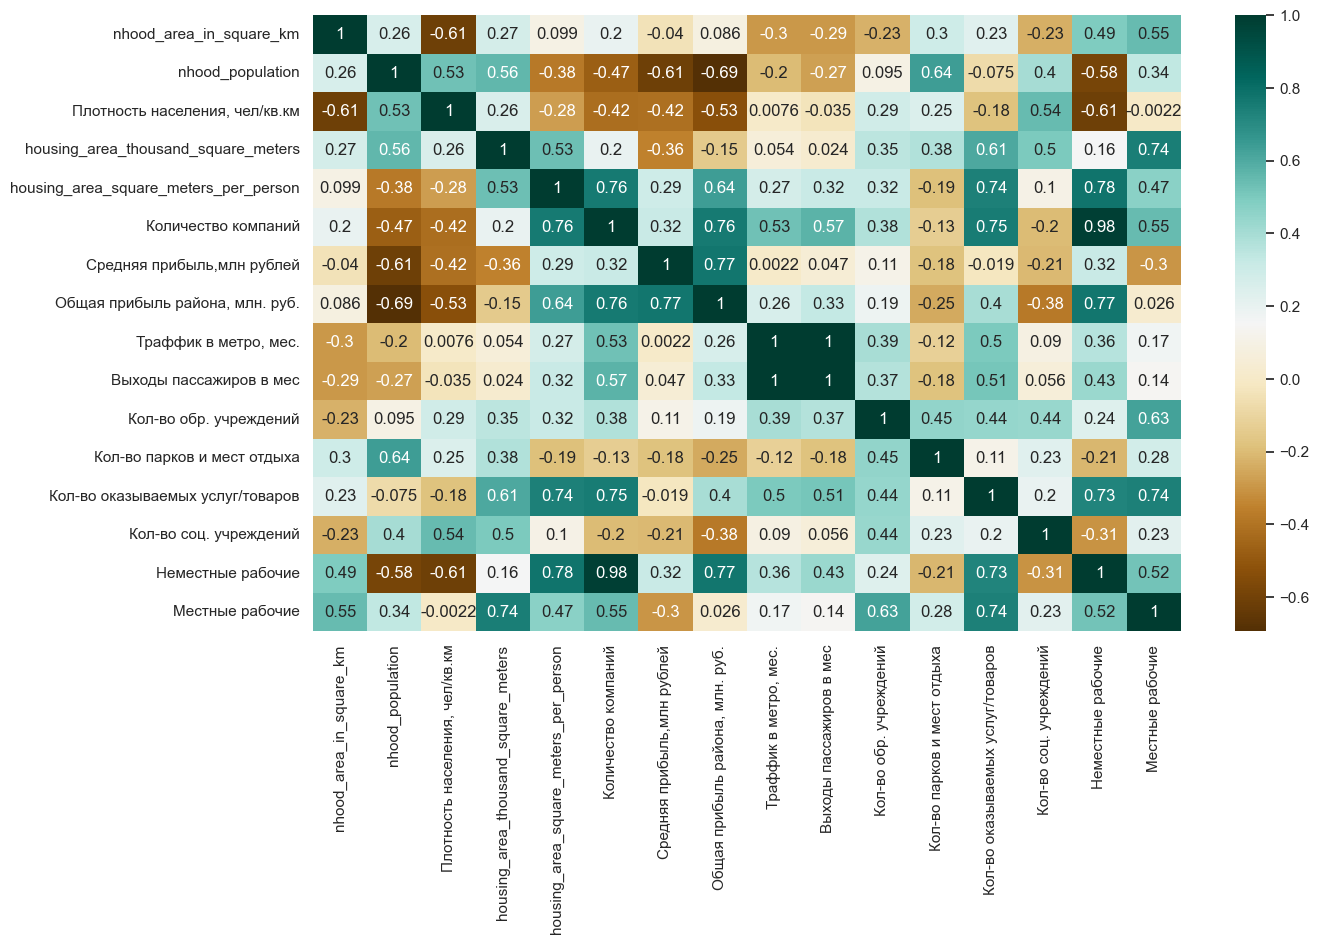

In [608]:
old_moscow_district = old_moscow.drop(columns=["arenda_A", "vacancy_lvl_A", "arenda_B", "vacancy_lvl_B", 
                                               "building_permissions"])
corr = old_moscow_district[old_moscow_district.Округ == "южный"].corr()
sns.set(rc={'figure.figsize':(14,8)})
sns.heatmap(corr, cmap="BrBG", annot=True)

<AxesSubplot:>

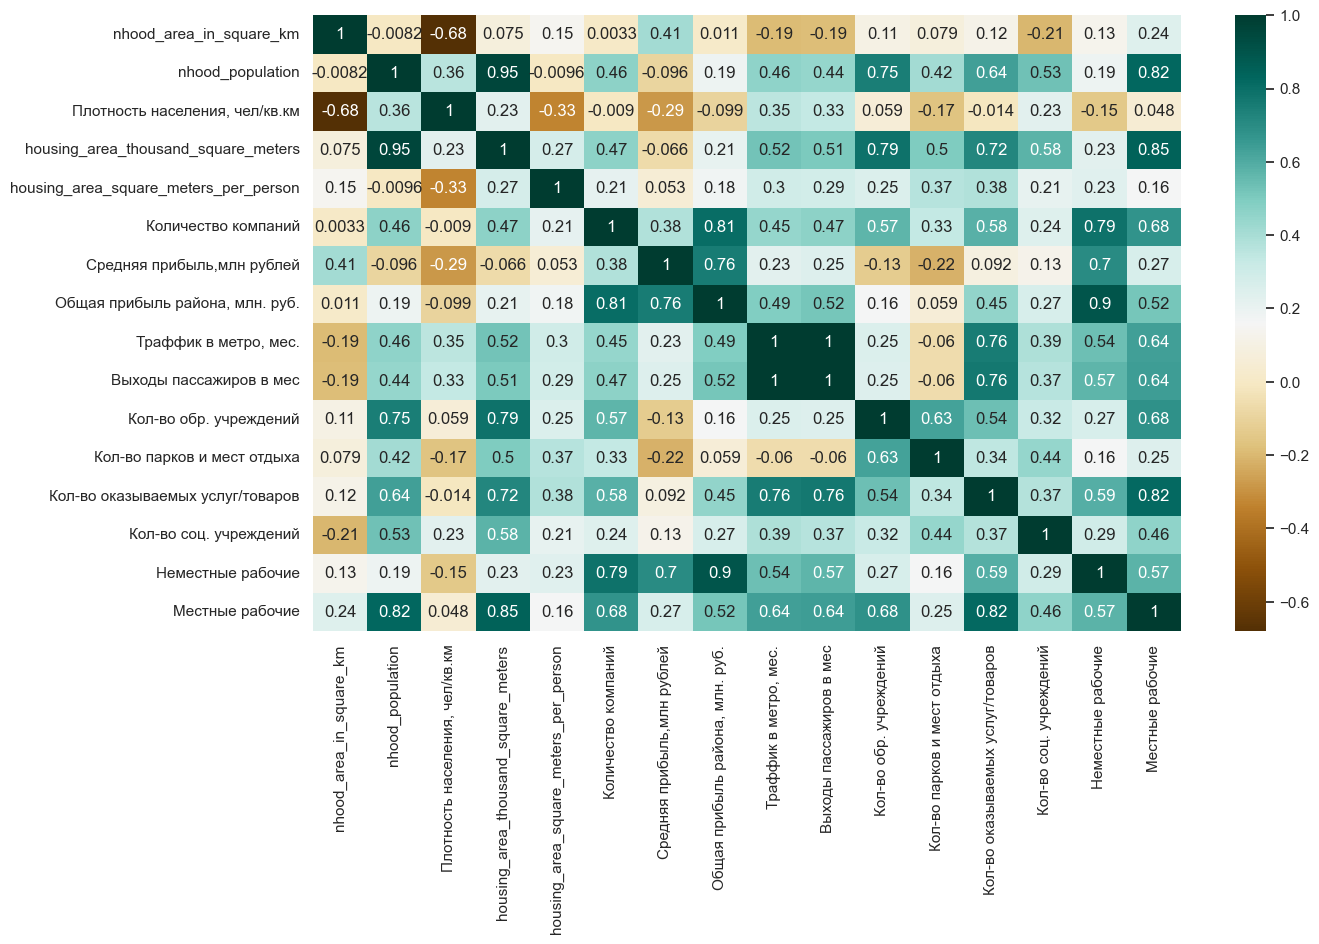

In [609]:
old_moscow_district = old_moscow.drop(columns=["arenda_A", "vacancy_lvl_A", "arenda_B", "vacancy_lvl_B", 
                                               "building_permissions"])
corr = old_moscow_district[old_moscow_district.Округ == "восточный"].corr()
sns.set(rc={'figure.figsize':(14,8)})
sns.heatmap(corr, cmap="BrBG", annot=True)

<AxesSubplot:>

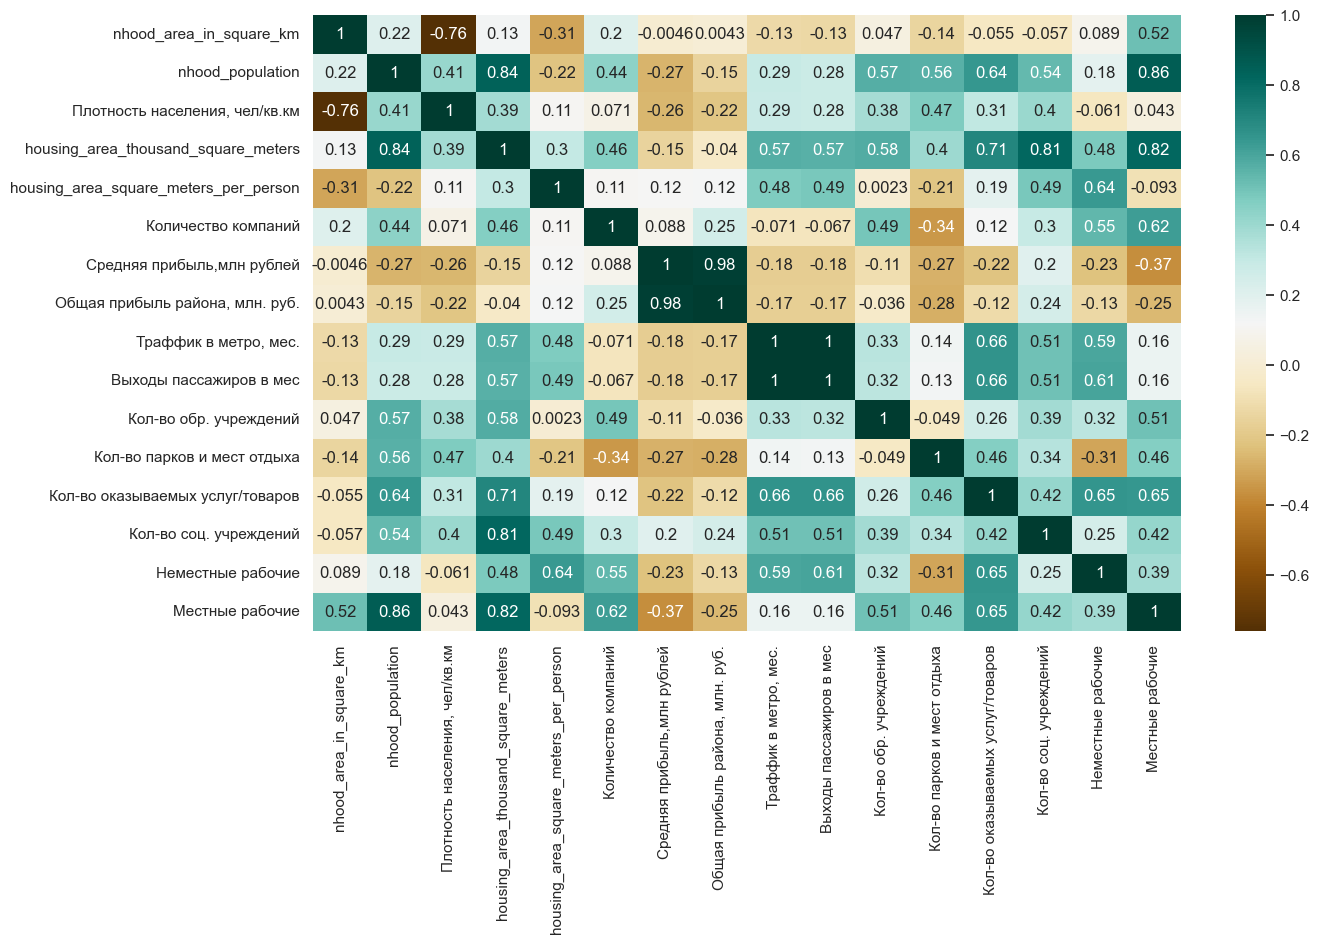

In [610]:
old_moscow_districts = old_moscow.drop(columns=["arenda_A", "vacancy_lvl_A", "arenda_B", "vacancy_lvl_B", 
                                               "building_permissions"])
corr = old_moscow_districts[old_moscow_districts.Округ == "западный"].corr()
sns.set(rc={'figure.figsize':(14,8)})
sns.heatmap(corr, cmap="BrBG", annot=True)

In [619]:
def set_districts_rank(old_moscow_districts, adm_district):
    
    def assign_rank(frame, fieldname, rank_fieldname, sorting=True):
        frame = frame.sort_values(by=[fieldname], ascending=sorting)
        frame = frame.assign(rank=frame.groupby(fieldname).ngroup(ascending=sorting).add(1))
        frame = frame.rename(columns={"rank": rank_fieldname})
        return frame

    cols_to_save=[
        "Округ",
        "Район", 
        "Плотность населения, чел/кв.км", 
        "Количество компаний", 
        "Общая прибыль района, млн. руб.",
        "Траффик в метро, мес.", 
        "Кол-во обр. учреждений", 
        "Кол-во парков и мест отдыха", 
        "Кол-во оказываемых услуг/товаров", 
        "Кол-во соц. учреждений",
        "Неместные рабочие", 
        "Местные рабочие"
    ]

    cols_to_rename = {
        "neighborhood": "Район",
        "administrative_district": "Округ",
        "nhood_population_density_person_per_square_km": "Плотность населения, чел/кв.км",
        "Входы пассажиров в мес": "Траффик в метро, мес.",
        "Общая прибыль,млн рублей": "Общая прибыль района, млн. руб.",
        "sum_edu": "Кол-во обр. учреждений",
        "sum_leisures": "Кол-во парков и мест отдыха",
        "sum_services": "Кол-во оказываемых услуг/товаров",
        "sum_socials": "Кол-во соц. учреждений",
        "nonresident_workers": "Неместные рабочие",
        "resident_workers": "Местные рабочие",
    }

    cols_to_rank = [
        "DensityRank", "CompaniesRank", "ProfitRank", "TrafficRank", "EducationRank", "LeisureRank", "ServiceRank",
        "SocialRank", "NonresidentRank", "ResidentRank"
    ]
    
    cols_to_return = [
        "Округ", "Район", "DensityRank", "CompaniesRank", "ProfitRank", "TrafficRank", "EducationRank", "LeisureRank", "ServiceRank",
        "SocialRank", "NonresidentRank", "ResidentRank", "SummaryRank",
    ]
    
    
    district = old_moscow_districts[old_moscow_districts.Округ == adm_district]
    district = district[cols_to_save]
    district = district.rename(columns=cols_to_rename)
    
    frame = assign_rank(district, "Плотность населения, чел/кв.км", "DensityRank", sorting=False)
    frame = assign_rank(frame, "Количество компаний", "CompaniesRank", sorting=True)
    frame = assign_rank(frame, "Общая прибыль района, млн. руб.", "ProfitRank", sorting=True)
    frame = assign_rank(frame, "Траффик в метро, мес.", "TrafficRank", sorting=False)
    frame = assign_rank(frame, "Кол-во обр. учреждений", "EducationRank", sorting=True)
    frame = assign_rank(frame, "Кол-во парков и мест отдыха", "LeisureRank", sorting=True)
    frame = assign_rank(frame, "Кол-во оказываемых услуг/товаров", "ServiceRank", sorting=True)
    frame = assign_rank(frame, "Кол-во соц. учреждений", "SocialRank", sorting=True)
    frame = assign_rank(frame, "Неместные рабочие", "NonresidentRank", sorting=True)
    frame = assign_rank(frame, "Местные рабочие", "ResidentRank", sorting=True)
    
    frame = frame.assign(SummaryRank=frame[cols_to_rank].sum(axis=1))
    frame = frame.sort_values(by=["SummaryRank"], ascending=False)

    return frame[cols_to_return]

In [620]:
# назначаем ранги

central_district = set_districts_rank(old_moscow_districts, "центральный")
west_district = set_districts_rank(old_moscow_districts, "западный")
north_district = set_districts_rank(old_moscow_districts, "северный")
south_district = set_districts_rank(old_moscow_districts, "южный")
east_district = set_districts_rank(old_moscow_districts, "восточный")
south_west_district = set_districts_rank(old_moscow_districts, "юго-западный")
south_east_district = set_districts_rank(old_moscow_districts, "юго-восточный")
north_east_district = set_districts_rank(old_moscow_districts, "северо-восточный")
north_west_district = set_districts_rank(old_moscow_districts, "северо-западный")
zeleno_district = set_districts_rank(old_moscow_districts, "зеленоградский")

In [623]:
# соединяем район с картой и рисуем

gdf_2 = preprocess(gdf, "adm_name")
mos = gdf_2.merge(central_district, how="inner", left_on="adm_name", right_on="Район")

<AxesSubplot:>

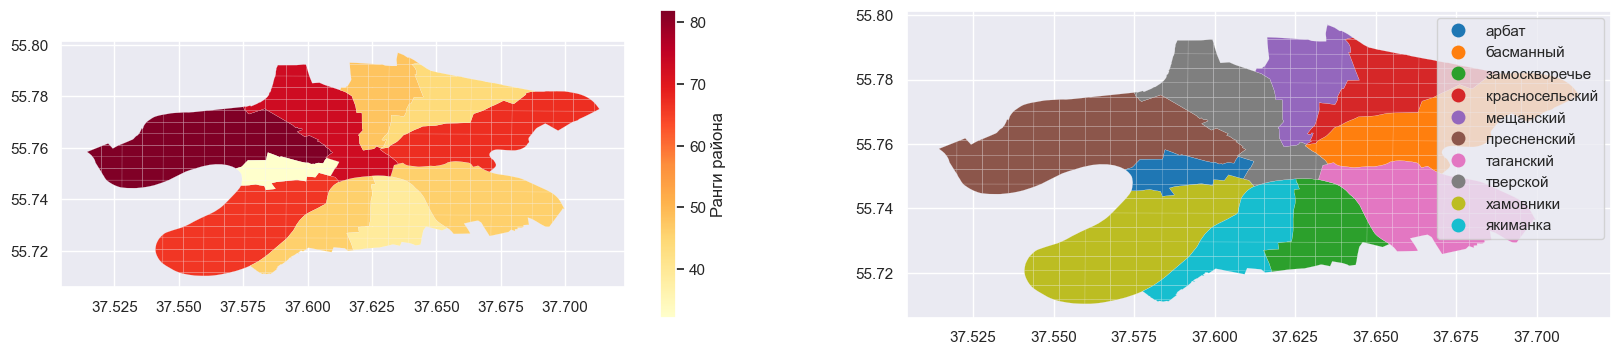

In [624]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
mos.plot(ax=ax1,
        column="SummaryRank", 
        linewidth=0.1,
        cmap='YlOrRd',
        legend=True, 
        legend_kwds={'label': "Ранги района", 'shrink': 0.2},
        )
mos.plot(ax=ax2,
         column="Район", 
         linewidth=0.1, 
         legend=True, 
         legend_kwds={'loc': 'best'}, 
        )

In [625]:
central_district.T

,80,101,6,108,57,122,100,40,29,3
Округ,центральный,центральный,центральный,центральный,центральный,центральный,центральный,центральный,центральный,центральный
Район,пресненский,тверской,басманный,хамовники,мещанский,якиманка,таганский,красносельский,замоскворечье,арбат
DensityRank,6,8,4,7,5,10,2,9,3,1
CompaniesRank,9,8,10,7,5,1,4,6,3,2
ProfitRank,10,8,3,5,1,9,2,4,6,7
TrafficRank,3,1,2,7,8,10,4,6,5,9
EducationRank,8,6,9,4,3,2,7,3,5,1
LeisureRank,9,6,7,10,5,4,8,2,1,3
ServiceRank,9,10,8,5,4,1,7,2,6,3
SocialRank,9,8,7,10,6,3,2,1,5,4
